## The Problem (Looking at the big picture)

Welcome to Machine Learning Housing Corporation! The first task you are asked to
perform is to build a model of housing prices in California using the California census
data. This data has metrics such as the population, median income, median housing
price, and so on for each block group in California. Block groups are the smallest
geographical unit for which the US Census Bureau publishes sample data (a block
group typically has a population of 600 to 3,000 people). We will just call them “districts”
for short.
Your model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

## Getting the Data

In [1]:
import pandas as pd

def load_housing_data(dataset_path):
    return pd.read_csv(dataset_path)

In [2]:
housing = load_housing_data("dataset/housing.csv")

### A Quick look at the data structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# information on features
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
# a summary of numerical attributes(features) (excludes "ocean_proximity")
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a
histogram for each numerical attribute.

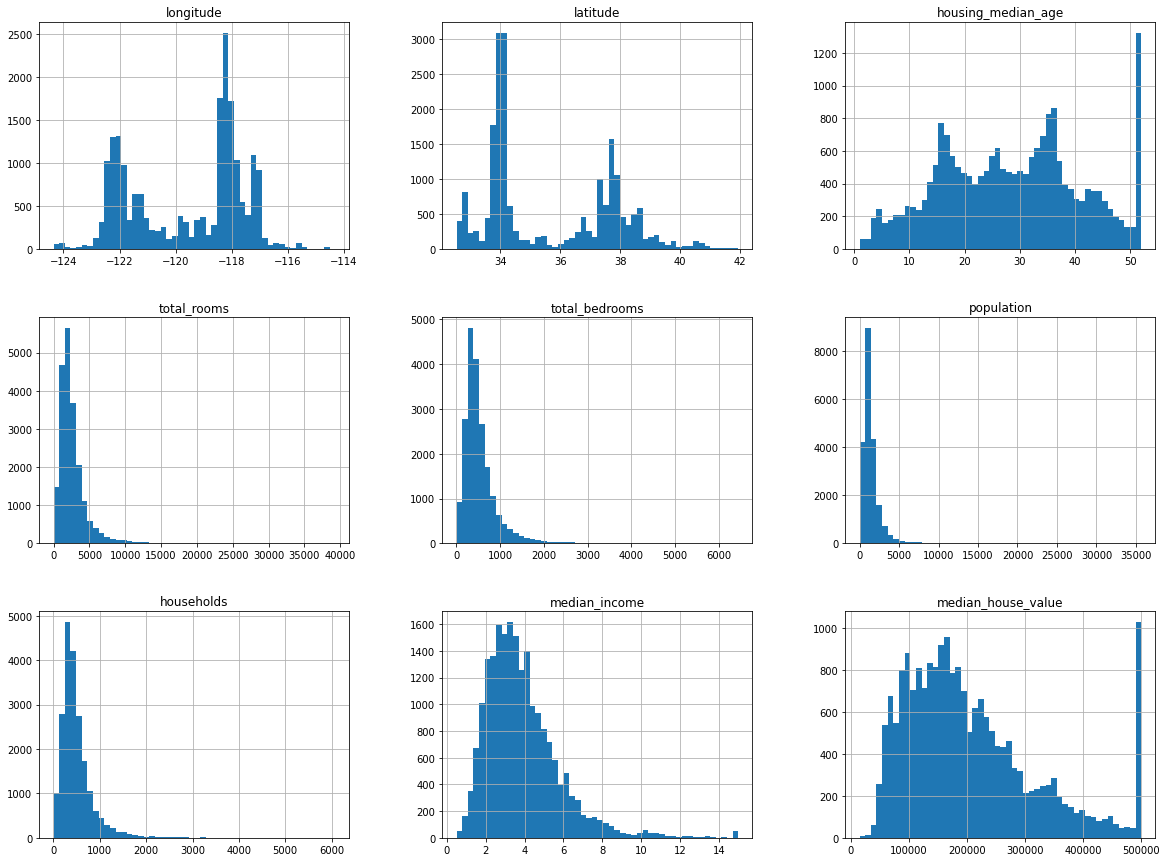

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Creating a test set
Creating a test set is theoretically quite simple: just pick some instances randomly,
typically 20% of the dataset, and set them aside. 

In [7]:
from sklearn.model_selection import train_test_split

training_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

The `random_state` parameter that allows you to set the random generator seed.
random_state is basically used so that it always generates the same shuffled indices. If you do not use a random_state in train_test_split, every time you make the split you might get a different set of train and test data points and will not help you in debugging in case you get an issue.

So far we have considered a random sampling method (). 
This is generally fine if your dataset is large enough (especially relative to the number of attributes), **but if it
is not, you run the risk of introducing a *significant sampling bias***.

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Suppose you chatted with experts who told you that the **median income** is a very **important attribute to predict median housing prices**.

You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute.

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [9]:
import numpy as np
# creates a new feature "income_cat"
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  income_cat          20640 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


Stratified random sampling is one common method that is used by researchers because it enables them to obtain a sample population that best represents the entire population being studied, making sure that each subgroup of interest is represented.

Performing stratified sampling based on the income category.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

Now you should remove the income_cat attribute so the data is back to its original state:

In [11]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Exploring data: Discover and Visualize the Data to Gain Insights
Test set must be kept aside and make sure you are only exploring the training set.

In [12]:
# a copy of the training set
housing = strat_train_set.copy()

`housing` is a DataFrame object. (thats from the pandas library) Read more on plotting with pandas [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html)

### Visualizing geographical data


A scatterplot of all districts using the geographical information (latitude and longtitude)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

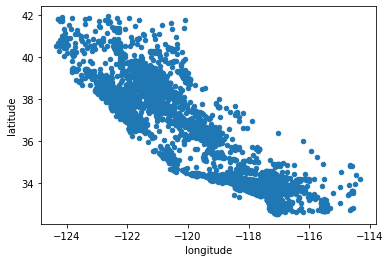

In [13]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

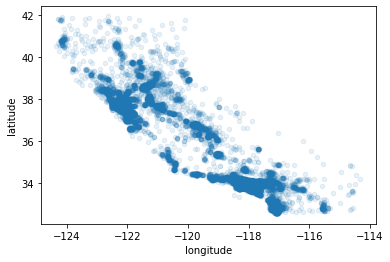

In [14]:
# by decreasing the opacity of each point, you can observe where there is high density of data points.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

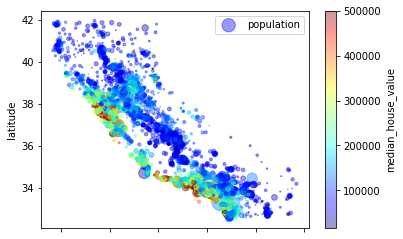

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing['population']/100, c="median_house_value", label="population",
            cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

`s` - the size of each data point. 
`c` - the color of each point.
Therefore, with the above parameters, The size of each data point, `s` represents the **population** and The color of each point, `c` represents the **median_house_value**.

From the plot, we can observe that the high density places have a higher median_house_value.

This image tells you that the housing prices are very much related to the location and to the population density, as you probably knew already.

### Looking for correlations

In [17]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
income_cat            0.642256
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

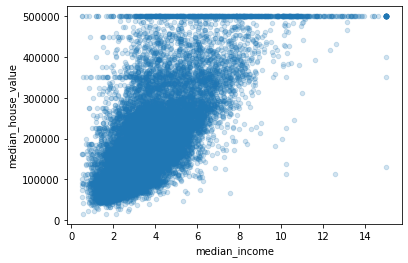

In [12]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2)

Experimenting with feature combinations

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out **various feature combinations**. For example, the total *number of rooms* in a district is not very useful if you don’t know how many
*households* there are. What you really want is the **number of rooms per household**.


In [14]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16354 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_room         16354 non-null  float64
 12  population_per_household  16512 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


In [15]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. 

Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are. 

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Preparing data for Machine Learning Algorithms

First, let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values.

In [16]:
# separating predictors and labels

# predictors
housing = strat_train_set.drop("median_house_value", axis=1)   # creates a copy of the training set excluding the target values (median_house_value)

# labels
housing_labels = strat_train_set["median_house_value"].copy()   # creates a copy of only the labels (median_house_value)

(note that drop() creates a copy of the data and does not affect strat_train_set):

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

• **Get rid of the corresponding districts.**

• **Get rid of the whole attribute.**

• **Set the values to some value (zero, the mean, the median, etc.).**

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

`housing.dropna(subset=["total_bedrooms"]) # option 1`

`housing.drop("total_bedrooms", axis=1) # option 2`

`median = housing["total_bedrooms"].median()`

`housing["total_bedrooms"].fillna(median) # option 3`

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: **Imputer**. 
Here is how to use it. First, you need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [17]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
dir(imputer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_feature_names',
 '_check_n_features',
 '_concatenate_indicator',
 '_dense_fit',
 '_fit_indicator',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse_fit',
 '_transform_indicator',
 '_validate_data',
 '_validate_input',
 'add_indicator',
 'copy',
 'fill_value',
 'fit',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'missing_values',
 'set_params',
 'strategy',
 'transform',
 'verbose']

Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [18]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


fit the imputer instance to the training data using the fit() method:

In [19]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The **imputer** has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [20]:
imputer.statistics_    # computed median values of all features.

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [22]:
X = imputer.transform(housing_num)    # replaces missing values by the learned medians.
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

The result is a plain Numpy array containing the transformed features. If you want to put it back into a Pandas DataFrame, it’s simple:

In [23]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [24]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


### Handling Text and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median. 

Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these text labels to numbers. 


### Integer Encoding
Assigning numbers to labels or categorical data.

**Machine learning algorithms cannot work with categorical data directly. Categorical data must be converted to numbers.**

Scikit-Learn provides a transformer for this task called `LabelEncoder`:

In [25]:
from sklearn.preprocessing import LabelEncoder
# an instance
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]   # a copy of only the ocean_proximity feature (text/categorical attribute)
housing_cat_encoded = encoder.fit_transform(housing_cat)

In [26]:
housing_cat_encoded

array([1, 4, 1, ..., 0, 0, 1])

In [27]:
housing_cat

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
            ...    
15174     <1H OCEAN
12661        INLAND
19263     <1H OCEAN
19140     <1H OCEAN
19773        INLAND
Name: ocean_proximity, Length: 16512, dtype: object

This is better: now we can use this numerical data in any ML algorithm. 
    
You can look at the mapping that this encoder has learned using the `classes_` attribute (“<1H OCEAN” is mapped to 0, “INLAND” is mapped to 1, etc.):

In [28]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

### One hot encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [30]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [38]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [40]:
housing.values

array([[-121.46, 38.52, 29.0, ..., 706.0, 2.1736, 'INLAND'],
       [-117.23, 33.09, 7.0, ..., 768.0, 6.3373, 'NEAR OCEAN'],
       [-119.04, 35.37, 44.0, ..., 300.0, 2.875, 'INLAND'],
       ...,
       [-122.72, 38.44, 48.0, ..., 172.0, 3.1797, '<1H OCEAN'],
       [-122.7, 38.31, 14.0, ..., 501.0, 4.1964, '<1H OCEAN'],
       [-122.14, 39.97, 27.0, ..., 197.0, 3.1319, 'INLAND']], dtype=object)

### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6     # index of each feature in the dataset.

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
            

In [45]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)